In [1]:
! pip install -r requirements.txt

  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/8d/29/076999b69bd9264b8df5e56f2be18da2de6b2a2d0e10737e5307592e01de/numpy-2.2.3-cp311-cp311-macosx_14_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 483.5 kB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for scipy from https://files.pythonhosted.org/packages/61/d8/84da3fffefb6c7d5a16968fe5b9f24c98606b165bb801bb0b8bc3985200f/scipy-1.15.2-cp311-cp311-macosx_14_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.6 MB/s eta 0:00:0000:01
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/25/92/ee1d7a00bb6b8c55755d4984fd82608603a3cc59959245068ce32e7fb808/scikit_learn-1.6.1-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/0a/e4/300b08e3e08f9c98b0d5635f42edabf2f7a1d634e64cb0318a71a44ff720/matplotlib-3

In [81]:
import polars as pl
from matplotlib import pyplot as plt 
import numpy as np 
import pylink 
import scipy
import time
import matplotlib as mpl
from scipy.stats import Normal, cramervonmises, skewnorm
import random

In [61]:
# read RTT output for <num_seconds> and redirect to file <filename>
def rtt_to_file(filename, num_seconds):
    POLL_FREQ = 10.
    max_count = num_seconds * POLL_FREQ
    count = 0

    jlink = pylink.JLink()
    jlink.open()
    jlink.set_tif(pylink.enums.JLinkInterfaces.SWD)
    jlink.set_speed(10_000)
    jlink.connect("MKL03Z32XXX4")
    jlink.rtt_start()
    
    with open(filename, 'w') as f:
        while jlink.connected():
            try:
                terminal_bytes = jlink.rtt_read(0, 4096)
                if terminal_bytes:
                    s = "".join(map(chr, terminal_bytes))
                    print(f"writing {len(s)} bytes to file")
                    f.write(s)
                count += 1
                if count >= max_count:
                    jlink.close()
                    return
                time.sleep(1. / POLL_FREQ)
            except Exception as e:
                jlink.close()
                raise e

In [11]:
rtt_to_file("data/stationary-2.json", 120)

writing 99 bytes to file
writing 435 bytes to file
writing 556 bytes to file
writing 231 bytes to file
writing 528 bytes to file
writing 529 bytes to file
writing 175 bytes to file
writing 616 bytes to file
writing 518 bytes to file
writing 98 bytes to file
writing 154 bytes to file
writing 528 bytes to file
writing 539 bytes to file
writing 102 bytes to file
writing 293 bytes to file
writing 523 bytes to file
writing 406 bytes to file
writing 374 bytes to file
writing 539 bytes to file
writing 319 bytes to file
writing 518 bytes to file
writing 549 bytes to file
writing 165 bytes to file
writing 56 bytes to file
writing 560 bytes to file
writing 539 bytes to file
writing 169 bytes to file
writing 152 bytes to file
writing 511 bytes to file
writing 548 bytes to file
writing 11 bytes to file
writing 220 bytes to file
writing 539 bytes to file
writing 473 bytes to file
writing 385 bytes to file
writing 518 bytes to file
writing 329 bytes to file
writing 441 bytes to file
writing 549 byte

In [172]:
df = pl.read_ndjson("data/sitting.json")
df.head()

type,group,sample_num,Re,Im,Mag
str,i64,i64,i64,i64,i64
"""TIME""",0,0,8576,0,8576
"""TIME""",0,1,8579,0,8579
"""TIME""",0,2,8583,0,8583
"""TIME""",0,3,8598,0,8598
"""TIME""",0,4,8608,0,8608


In [62]:
TIME_SCALE = 8192.
FREQ_SCALE = 4096.

In [63]:
# assumes magnitudes are of shape 64
def downsample_fft(magnitudes):
    output = np.zeros(7)
    output[0] = magnitudes[0]
    for i in range(6):
        output[i+1] = np.sum(magnitudes[(5*i)+1:1+5*(i+1)])
    return output

def klo3_downsample(magnitudes):
    output = np.zeros(7)
    output[0] = magnitudes[0]
    for i in range(1, 31):
        output[((i - 1) // 5) + 1] += magnitudes[i]
    return output

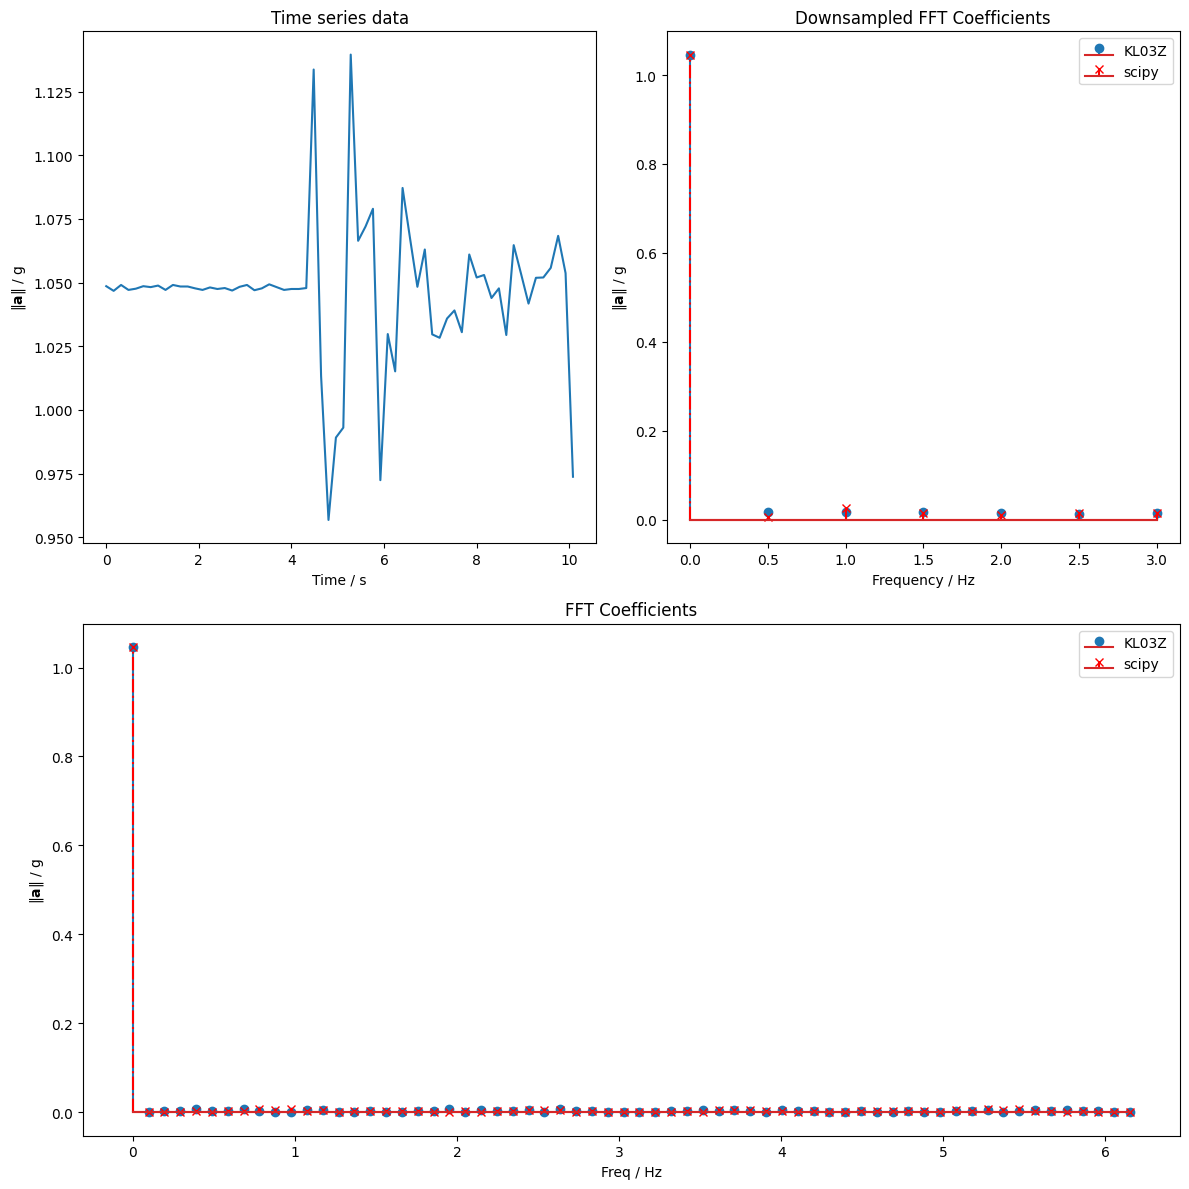

In [233]:
group = df.select(pl.col("group").sample(1)).item()
time_series = df.filter(
    (pl.col("group") == group) & (pl.col("type") == "TIME")
).sort("sample_num")
coefficients = df.filter(
    (pl.col("group") == group) & (pl.col("type") == "FREQ")
).sort("sample_num")

# fig, axs = plt.subplots(2, 1, figsize=(15, 15))
fig, axs = plt.subplot_mosaic([["A", "B"],
                               ["C", "C"]], 
                              figsize=(12, 12))

ax1 = axs["A"]
ax2 = axs["B"]
ax3 = axs["C"]

time_x = time_series["sample_num"].to_numpy() / 6.25
freq_x = coefficients["sample_num"].to_numpy() * 6.25 / 64.

time_y = time_series["Mag"].to_numpy() / TIME_SCALE
freq_y = coefficients["Mag"].to_numpy() / FREQ_SCALE
coefs = np.absolute(
    scipy.fft.fft(time_series["Mag"].to_numpy() / TIME_SCALE, norm="forward")
)

ax1.plot(time_x, time_y)
ax1.set_title("Time series data")
ax1.set_xlabel("Time / s")
ax1.set_ylabel("$\\|\\mathbf{a}\\|$ / g")

downsample_x = np.linspace(0, 3, 7)
ax2.stem(downsample_x, downsample_fft(freq_y), label="KL03Z")
ax2.stem(downsample_x, downsample_fft(coefs), label="scipy", linefmt="-.r", markerfmt="xr")
ax2.set_title("Downsampled FFT Coefficients")
ax2.set_xlabel("Frequency / Hz")
ax2.set_ylabel("$\\|\\mathbf{a}\\|$ / g")
ax2.legend()

ax3.stem(freq_x, freq_y, label="KL03Z")
ax3.stem(freq_x, coefs, label="scipy", linefmt="-.r", markerfmt="xr")
ax3.set_title("FFT Coefficients")
ax3.set_xlabel("Freq / Hz")
ax3.set_ylabel("$\\|\\mathbf{a}\\|$ / g")
ax3.legend()

fig.tight_layout()
plt.show()

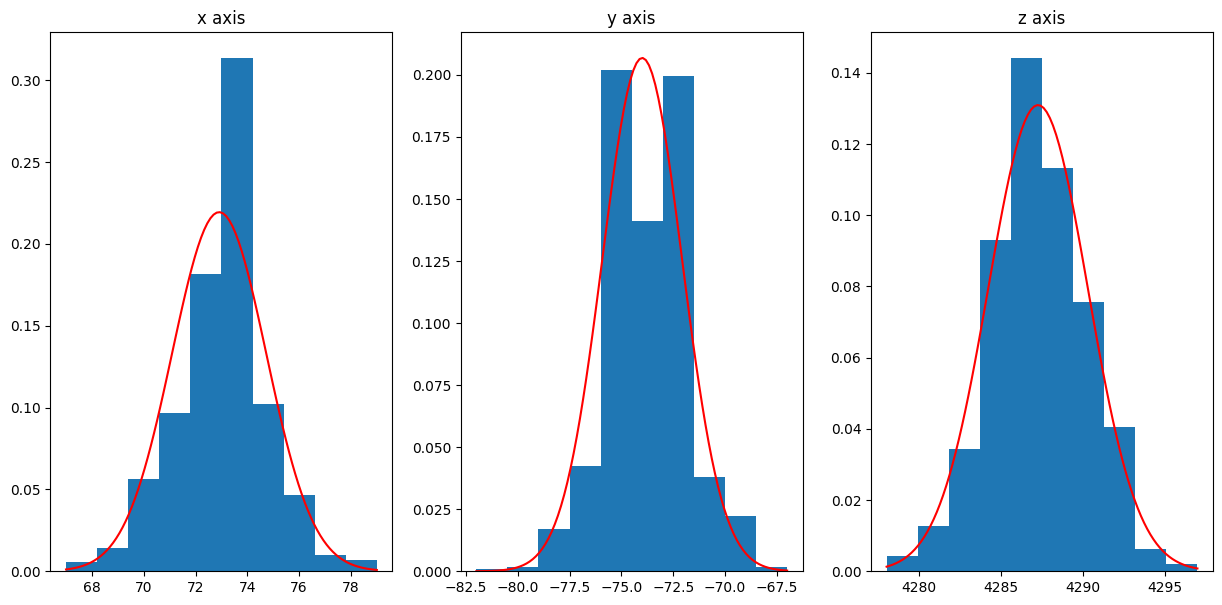

In [191]:
data = pl.read_ndjson("data/stationary-2.json").filter(pl.col("type") == "AXES")
fig, axs = plt.subplots(ncols=3, figsize=(15, 7))
ax1, ax2, ax3 = axs.flat

x_readings = data["x"].to_numpy()
y_readings = data["y"].to_numpy()
z_readings = data["z"].to_numpy()

x_dist = Normal(mu=np.mean(x_readings), sigma=np.std(x_readings))
y_dist = Normal(mu=np.mean(y_readings), sigma=np.std(y_readings))
z_dist = Normal(mu=np.mean(z_readings), sigma=np.std(z_readings))

_, x_bins, _ = ax1.hist(x_readings, density=True)
_, y_bins, _ = ax2.hist(y_readings, density=True)
_, z_bins, _ = ax3.hist(z_readings, density=True)

xx = np.linspace(x_bins[0], x_bins[-1], 100)
yx = np.linspace(y_bins[0], y_bins[-1], 100)
zx = np.linspace(z_bins[0], z_bins[-1], 100)

ax1.plot(xx, x_dist.pdf(xx), color="red")
ax2.plot(yx, y_dist.pdf(yx), color="red")
ax3.plot(zx, z_dist.pdf(zx), color="red")

ax1.set_title("x axis")
ax2.set_title("y axis")
ax3.set_title("z axis")

plt.show()

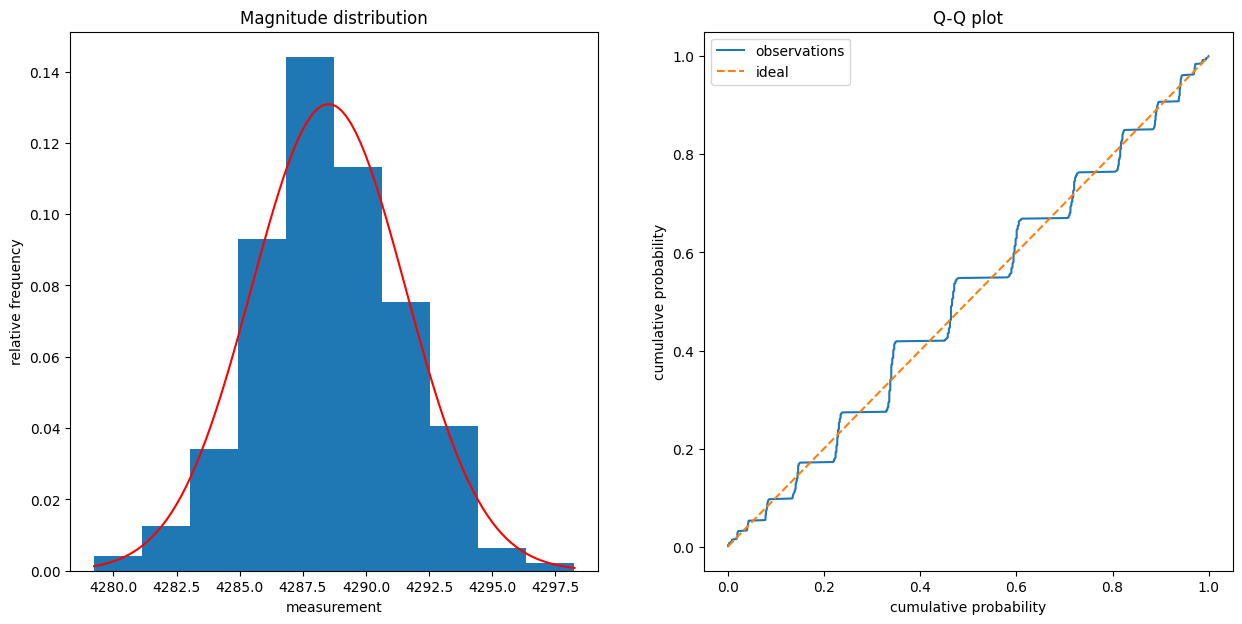

In [182]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 7))
mags = np.sqrt(x_readings**2 + y_readings**2 + z_readings**2)
mag_dist = Normal(mu=np.mean(mags), sigma=np.std(mags))
ax1.hist(mags, density=True)
x = np.linspace(np.min(mags), np.max(mags), 100)
ax1.plot(x, mag_dist.pdf(x), color="red")
ax1.set_title("Magnitude distribution")
ax1.set_xlabel("measurement")
ax1.set_ylabel("relative frequency")

s = np.sort(mags)
q = np.cumsum(np.ones_like(s)) / len(s)
y = mag_dist.cdf(s)

ax2.plot(y, q, label="observations")
ax2.plot(y, y, label="ideal", linestyle="--")
ax2.set_title("Q-Q plot")
ax2.legend()
ax2.set_xlabel("cumulative probability")
ax2.set_ylabel("cumulative probability")

plt.savefig("./figures/qq.jpg", dpi=800)
plt.show()

walking -> 12 samples
stationary -> 95 samples
jogging -> 12 samples
sitting -> 12 samples


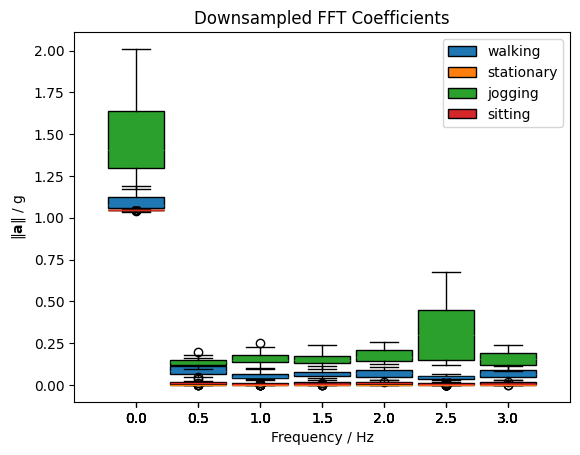

In [183]:
colors = mpl.colormaps["tab10"]
distributions = {}
samples = {}

FILENAMES = ["walking", "stationary", "jogging", "sitting"]

for (i, filename) in enumerate(FILENAMES):
    df = pl.read_ndjson(f"data/{filename}.json")
    downsampled = []
    groups = df.select(pl.col("group").unique())["group"].to_list()
    for group in groups:
        coefficients = df.filter(
            (pl.col("group") == group) & (pl.col("type") == "FREQ")
        ).sort("sample_num")["Mag"].to_numpy()
        downsampled.append(downsample_fft(coefficients))

    samples[filename] = downsampled
    downsampled = np.array(downsampled)
    print(f"{filename} -> {downsampled.shape[0]} samples")

    distributions[filename] = np.mean(downsampled, axis=0), np.std(downsampled, axis=0)
    
    bplot = plt.boxplot(downsampled / FREQ_SCALE, 
                         positions=np.linspace(0, 3.0, 7), 
                         patch_artist=True,
                         medianprops={"color": colors(i)},
                         label=filename)
    
    for patch in bplot['boxes']:
        patch.set_facecolor(colors(i))

plt.legend()
plt.title("Downsampled FFT Coefficients")
plt.xlabel("Frequency / Hz")
plt.ylabel("$\\|\\mathbf{a}\\|$ / g")
plt.savefig("./figures/fft-coefs.jpg", dpi=800)
plt.show()

In [163]:
def classify(sample, data):
    probs = {}
    dist = Normal(mu=0, sigma=1)
    total = 0.
    
    for label, (mean, std) in data.items():
        acc = 1.
        for (i, x_i) in enumerate(sample):
            scaled = abs((x_i - mean[i]) / std[i])
            p = 1. - dist.cdf(scaled)
            acc *= p
        
        probs[label] = acc
        total += acc 
        
    inference = {}
    for label, prob in probs.items():
        inference[label] = prob / total
          
    return inference

In [174]:
def get_confusion_matrix(noise_std):
    data = []
    noise = Normal(mu=0, sigma=noise_std)
    for filename in FILENAMES:
        for sample in samples[filename]:
            for _ in range(10):
                output = classify(sample + noise.sample(sample.shape), distributions)
                output["label"] = filename 
                data.append(output)
    
    inference = pl.from_dicts(data)
    return (inference
           .group_by("label")
           .agg(pl.all().mean())
           .sort("label")
           .select(sorted(inference.columns))
           .select(pl.all().exclude("label")))

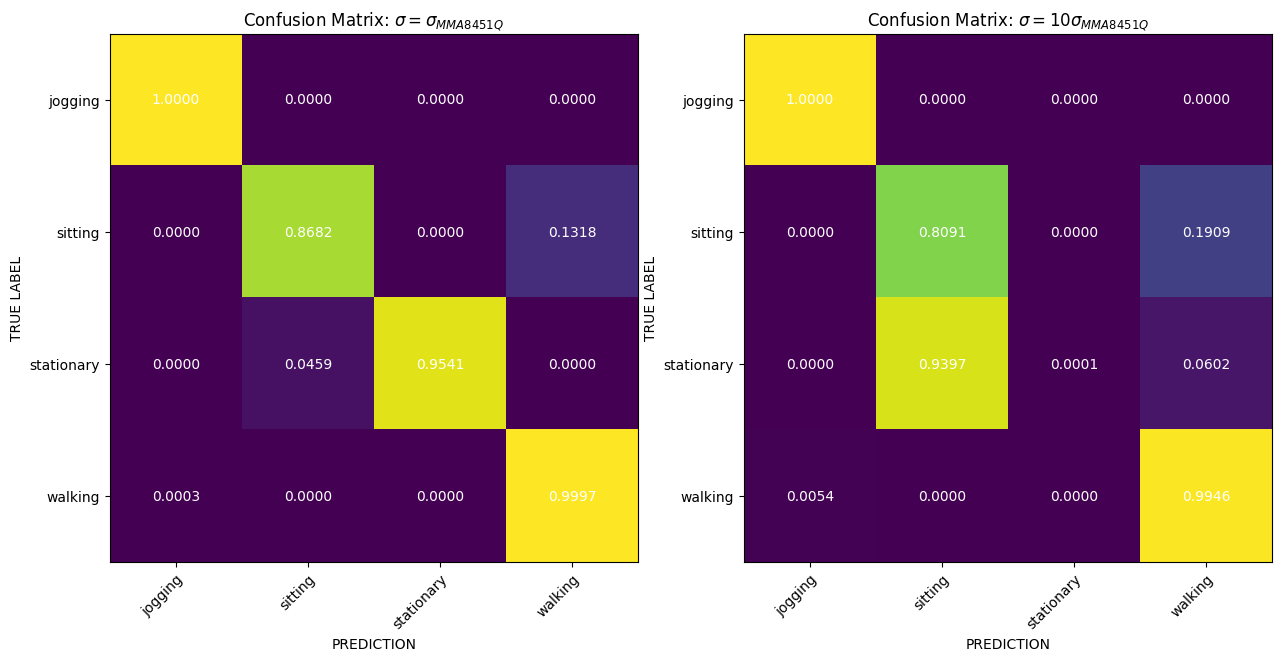

In [184]:
cm1 = get_confusion_matrix(1. * np.std(mags))
cm10 = get_confusion_matrix(10. * np.std(mags))

fig, (ax1, ax10) = plt.subplots(ncols=2, figsize=(15, 7))
m1 = cm1.to_numpy()

ax1.imshow(m1)
ax1.set_xticks(range(len(cm1.columns)), labels=cm1.columns, rotation=45, ha="right", rotation_mode="anchor")
ax1.set_yticks(range(len(cm1.columns)), labels=cm1.columns)
ax1.set_xlabel("PREDICTION")
ax1.set_ylabel("TRUE LABEL")

for i in range(len(cm1.columns)):
    for j in range(len(cm1.columns)):
        ax1.text(j, i, f"{m1[i, j]:.4f}", ha="center", va="center", color="w")

m10 = cm10.to_numpy()

ax10.imshow(m10)
ax10.set_xticks(range(len(cm10.columns)), labels=cm10.columns, rotation=45, ha="right", rotation_mode="anchor")
ax10.set_yticks(range(len(cm10.columns)), labels=cm10.columns)
ax10.set_xlabel("PREDICTION")
ax10.set_ylabel("TRUE LABEL")

for i in range(len(cm10.columns)):
    for j in range(len(cm10.columns)):
        ax10.text(j, i, f"{m10[i, j]:.4f}", ha="center", va="center", color="w")

ax1.set_title("Confusion Matrix: $\\sigma = \\sigma_{MMA8451Q}$")
ax10.set_title("Confusion Matrix: $\\sigma = 10\\sigma_{MMA8451Q}$")
plt.savefig("./figures/cm.jpg", dpi=800)
plt.show()

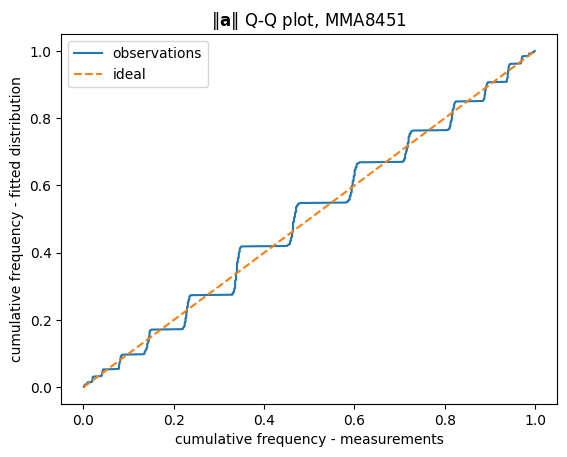

In [189]:
fig, ax = plt.subplots()
ax.plot(y, q, label="observations")
ax.plot(y, y, label="ideal", linestyle="--")
ax.set_title("$\\|\\mathbf{a}\\|$ Q-Q plot, MMA8451")
ax.legend()
ax.set_xlabel("cumulative frequency - measurements")
ax.set_ylabel("cumulative frequency - fitted distribution")
plt.savefig("./figures/q-q-plot.jpg", dpi=800)
plt.show()

In [243]:
for k, (mean, std) in distrubutions.items():
    print(k)
    print(",".join([str(x) for x in mean.astype(np.int16)]))
    print(",".join([str(x) for x in std.astype(np.int16)]))
    print("--------")

walking
4475,394,222,279,286,178,277
201,185,75,85,107,58,104
--------
stationary
4279,1,1,1,2,1,2
2,5,5,3,7,9,7
--------
jogging
6046,525,656,628,745,1316,654
1039,149,170,157,178,719,183
--------
sitting
4283,59,43,48,51,38,53
9,49,32,35,31,29,39
--------


In [260]:
dist = Normal(mu=0, sigma=1)
cdf = dist.cdf(np.arange(0, 3 << 7, 1).astype(np.float64) / 128.)
((1. - cdf) * 1024).astype(np.int16)

array([512, 508, 505, 502, 499, 496, 492, 489, 486, 483, 480, 476, 473,
       470, 467, 464, 461, 457, 454, 451, 448, 445, 442, 438, 435, 432,
       429, 426, 423, 420, 417, 414, 410, 407, 404, 401, 398, 395, 392,
       389, 386, 383, 380, 377, 374, 371, 368, 365, 362, 359, 356, 353,
       350, 347, 344, 341, 338, 335, 333, 330, 327, 324, 321, 318, 315,
       313, 310, 307, 304, 301, 299, 296, 293, 291, 288, 285, 282, 280,
       277, 275, 272, 269, 267, 264, 261, 259, 256, 254, 251, 249, 246,
       244, 241, 239, 236, 234, 232, 229, 227, 224, 222, 220, 217, 215,
       213, 210, 208, 206, 204, 201, 199, 197, 195, 193, 191, 188, 186,
       184, 182, 180, 178, 176, 174, 172, 170, 168, 166, 164, 162, 160,
       158, 156, 154, 152, 151, 149, 147, 145, 143, 142, 140, 138, 136,
       135, 133, 131, 130, 128, 126, 125, 123, 121, 120, 118, 117, 115,
       114, 112, 111, 109, 108, 106, 105, 103, 102, 101,  99,  98,  96,
        95,  94,  92,  91,  90,  89,  87,  86,  85,  84,  82,  8

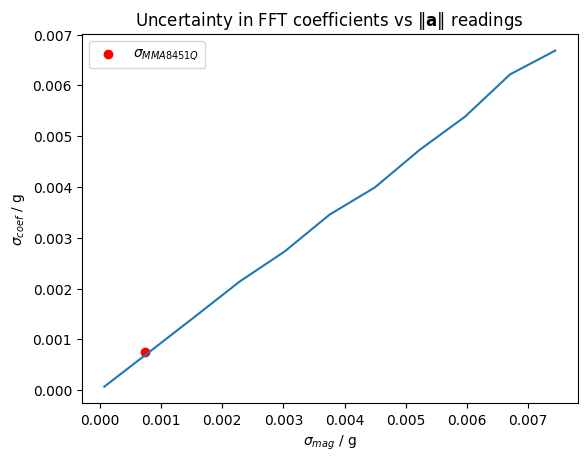

In [185]:
def downsample(magnitudes):
    output = np.zeros((7, magnitudes.shape[1]))
    output[0, :] = magnitudes[0, :]
    for i in range(6):
        output[i+1, :] = np.sum(magnitudes[(5*i)+1:1+5*(i+1), :], axis=0)
    return output

samples = { f: [] for f in FILENAMES }
for filename in FILENAMES:
    df = pl.read_ndjson(f"data/{filename}.json")
    groups = df.select(pl.col("group").unique())["group"].to_list()
    for group in groups:
        ts = df.filter(
            (pl.col("group") == group) & (pl.col("type") == "TIME")
        ).sort("sample_num")["Mag"].to_numpy()
        samples[filename].append(ts)

sigma = np.linspace(0.1 * np.std(mags), 10 * np.std(mags), 11)
noise = Normal(mu=0, sigma=sigma)
sample = random.choice(samples["walking"])
d = []

for _ in range(250):
    ts = np.reshape(sample, (sample.shape[0], 1)) + noise.sample(sample.shape[0])
    c = scipy.fft.fft(ts / TIME_SCALE, norm="forward", axis=0)
    d.append(downsample(np.absolute(c)))
    
noisy = np.stack(d, axis=0)
stds = noisy.std(axis=0).mean(axis=0)

plt.plot(sigma / 4096., stds * 9.81)
plt.scatter(np.std(mags)/4096., np.std(mags)/4096., label="$\\sigma_{MMA8451Q}$", color="red")
plt.legend()
plt.xlabel("$\\sigma_{mag}$ / g")
plt.ylabel("$\\sigma_{coef}$ / g")
plt.title("Uncertainty in FFT coefficients vs $\\|\\mathbf{a}\\|$ readings")
plt.savefig("./figures/sigma.jpg", dpi=800)
plt.show()

In [144]:
m = np.std(mags)
for k, (_, std) in distributions.items():
    nm = np.min(std / m)
    print(f"{k} -> Noise margin={nm:.3f}")

walking -> Noise margin=19.103
stationary -> Noise margin=0.846
jogging -> Noise margin=48.896
sitting -> Noise margin=3.247
